In [2]:
import requests
from bs4 import BeautifulSoup
import http.client
from dotenv import load_dotenv
import json

import pandas as pd
import numpy as np
from datetime import datetime
import time
import ast  # To safely evaluate the string as a dictionary
import pycountry
import re

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from matplotlib.ticker import FixedLocator

import os
import tkinter as tk
from tkinter import messagebox

In [3]:
# Construct City_country dataframe

# Create a mapping function for country abbreviations
def get_country_abbreviation(country_name):
    try:
         # use pycountry to get the country abbreviation
        country =  pycountry.countries.lookup(country_name)
        return country.alpha_2
    except LookupError:
         # If not found, return NaN
            # If not found, return NaN and print the country name
        #print(f"Country not found: {country_name}")
        return np.nan

# Get city_country dataframe
def city_country_dataframe():
    # load city, country dataframe
    city_country_df = pd.read_csv("worldcities.csv")

    # only select four colums:
    city_country_df = city_country_df[["city","lat","lng","country"]]

    # renmae column name
    city_country_df.rename(columns={"lng":"lon"},inplace=True)


    #apply(get_country_abbreviation) will pass each country name to the get_country_abbreviation function, which will return the 2-letter country code (if available).
    city_country_df["country_abbriev"] = city_country_df["country"].apply(get_country_abbreviation)
    # USA, UK
    city_country_df["country_abbriev"] = city_country_df["country_abbriev"].replace("US","USA") 
    city_country_df["country_abbriev"] = city_country_df["country_abbriev"].replace("GB","UK")      

    city_country_df.to_csv("city_country.csv")
    return city_country_df



# Function to handle form submission of city,country,check-in,check-out,num
def submit(city_country_df):
    city = city_entry.get()
    country = country_entry.get()
    destination = f"({city}, {country})"
    
    try:
       # validate city 
        if city.lower() not in city_country_df["city"].str.lower().to_list():
            raise ValueError("City not found! Please input a valid city!")
        
        # validate country
        country_match = (country.lower() in city_country_df["country"].str.lower().to_list()) or (country.upper() in city_country_df["country_abbriev"].str.upper().to_list())
        if not country_match:
            raise ValueError("Country not found! Please input a valid country!")
        
        # validate the combination of city and country
        # Filter for the specific city and country
        fil_location = (
        (city_country_df["city"].str.lower() == city.lower()) & 
        (
            (city_country_df["country"].str.lower() == country.lower()) | 
            (city_country_df["country_abbriev"].str.upper() == country.upper())
         )
        )

        # Extract latitude and longitude as scalar values
        if not fil_location.any():  # Check if the city-country combination exists
            raise ValueError(f"No data found for the location: {city}, {country}!")
        else:
            location_data = city_country_df.loc[fil_location].iloc[0]
            lat = location_data["lat"]  # Extract value
            lon = location_data["lon"]  # Extract value
            city = location_data["city"]
            country = location_data["country"]
    
        
        # validate date
        current_date = datetime.now()
        check_in_date_str = check_in_entry.get()
        check_out_date_str = check_out_entry.get()

        check_in_date = datetime.strptime(check_in_date_str, "%Y-%m-%d")
        check_out_date = datetime.strptime(check_out_date_str, "%Y-%m-%d")
        
        # Validate check-in date
        if check_in_date.date() < current_date.date():
            raise ValueError("Check-in date cannot be earlier than today. Please try again!")

        # Validate dates
        if check_in_date.date() >= check_out_date.date():
            raise ValueError("Check-out date must be later than check-in date. Please try again!")
        
        # Number of adults and children
        adult_num = int(adults_entry.get())
        if adult_num <= 0:
            raise ValueError("Number of adults must be at least 1!")
    
        
        children_num = int(children_entry.get())
        if children_num < 0:
            raise ValueError("Number of adults must be non-negative!")
        
        room_num = int(room_entry.get())
        if room_num <= 0:
            raise ValueError("Number of adults must be at least 1!")
        
        # Show confirmation message
        messagebox.showinfo("Booking Details are as follows:\n", 
                            f"The desired city: {city}!\n"
                            f"The desired country: {country}!\n"
                            f"The check-in date: {check_in_date.date()}\n"
                            f"The check-out date: {check_out_date.date()}\n"
                            f"The number of adults: {adult_num}\n"
                            f"The number of children: {children_num}\n"
                            f"The number of rooms: {room_num}\n")
        global location,period,num
        location = (city,country,lat,lon)
        period = (check_in_date,check_out_date)
        num = (adult_num,room_num,children_num)

        # Automatically shut down the GUI
        root.destroy()  # Close the GUI window
    
    except ValueError as e:
        messagebox.showerror("Input Error", str(e))



In [4]:
# hotel information via webscraping from booking.com

# ---------------------------------now start to change the variable in url----------------------------

def get_hotel_url(location,period,num):
    # room location
    city = location[0]
    country = location[1]
    
    # room time
    check_in_date = period[0]
    check_out_date = period[1]
 
    # room num
    adult_num = num[0]
    romm_num = num[1]
    children_num = num[2]

    hotel_url = f"https://www.booking.com/searchresults.en-gb.html?ss={city}%2C+Community+of+{city}%2C+{country}&efdco=1&label=gen173bo-1DCAEoggI46AdICVgDaMgBiAEBmAEJuAEXyAEM2AED6AEB-AEDiAIBmAICqAIDuAKNxYG6BsACAdICJDc4YzI3MmQ4LWM1NzMtNDE4MS04MTk0LTZlMTdkZWNjMWQwZdgCBOACAQ&sid=badcbe9c6b390c4f5668ded61093febe&aid=304142&lang=en-gb&sb=1&src_elem=sb&src=index&dest_id=-390625&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=d4b24c866c100605&ac_meta=GhBkNGIyNGM4NjZjMTAwNjA1IAAoATICZW46BE1hZHJAAEoAUAA%3D&checkin={check_in_date}&checkout={check_out_date}&group_adults={adult_num}&no_rooms={romm_num}&group_children={children_num}&order=price"

    return hotel_url


def get_container(url,headers):
    # request to the website
    response = requests.get(url,headers=headers)
    html= response.content
    soup = BeautifulSoup(html)

    # choose container
    hotel_container = soup.select("div > div.c624d7469d.a0e60936ad.a3214e5942.b0db0e8ada")

    container = []

    # filter out ad
    for con in hotel_container:
        # Check for ad markers
        if con.find("span", class_="b30f8eb2d6", string="Ad"):
            print("Ad found, skipping...")
            continue
        container.append(con)

    return container



#-------------------------------loop container to extract hote name, price, rating, vote---------------------------

# extract hote data
def selector_extract(item, selector):
    parse = item.select(selector)
    if parse:
        return parse[0].text
    else:
        return np.nan
    

def get_selector():
    selector = []
    
    name_selector = "a > div.f6431b446c.a15b38c233"
    selector.append(name_selector)

    price_selector = "div > span.f6431b446c.fbfd7c1165.e84eb96b1f"
    selector.append(price_selector)

    rating_selector = "div > div.ac4a7896c7"
    selector.append(rating_selector)

    vote_selector = "div > div.abf093bdfe.f45d8e4c32.d935416c47"
    selector.append(vote_selector)

    distance_selector = 'span > span[data-testid="distance"]'
    selector.append(distance_selector)

    return selector


def extract_hotel_web(container,selector,location):
    # selector 
    name_selector =  selector[0]
    price_selector =  selector[1]
    rating_selector =  selector[2]
    vote_selector =  selector[3]
    distance_selector =  selector[4]
   
    name_lst =[]
    price_lst = []
    rating_lst = []
    vote_lst = []
    distance_lst = []

    #loop container
    for con in container:
        #name
        name = selector_extract(con, name_selector)
        name_lst.append(name)

        #price
        price = selector_extract(con, price_selector)
        price_lst.append(price)


        #rating
        rating = selector_extract(con, rating_selector)
        vote = selector_extract(con, vote_selector)
        if (not "Scored" in rating) and (con.find("span", class_="b30f8eb2d6", string="New to Booking.com")):
            rating = np.nan
            vote = np.nan
        rating_lst.append(rating)
        vote_lst.append(vote)

        #distance
        distance = selector_extract(con, distance_selector)
        distance_lst.append(distance)

#    print(name_lst)
#    print(price_lst)
#    print(rating_lst)
#    print(vote_lst)
#    print(distance_lst)

    dic_hotel = {}

    city = location[0]
    country = location[1]

    dic_hotel = {"city":city,"country":country,"name":name_lst,"price":price_lst,"rating":rating_lst,"vote":vote_lst,"distance":distance_lst}

    return dic_hotel

In [5]:
# Weather information via connecting to API


# ------------------Load env information----------------------------
load_dotenv(dotenv_path=r"C:\Users\taoti\GitHub\Hotel_Recommendations\.env")

print(os.environ["weather_api_host"])
print(os.environ["weather_api_key"])

def get_weather_url(location):
    city = location[0]
    country = location[1]
    lat = location[2]
    lon = location[3]
    # get url variable
    weather_url = f"/forecast/daily?lat={lat}&lon={lon}&units=metric&lang=en"
    return weather_url 


# define function to extract data from API given url, conn
def extract_weather_API(city,url,conn,headers):
    try: 
        # Request to the API, and get data as the response
        conn.request("GET", url, headers=headers)
        res = conn.getresponse()
        data = res.read()

        # Parse JSON and extract data
        weather_data = json.loads(data)
        #print(f"Response for {city}: {weather_data}")
        
        if 'data' in weather_data:
                records = weather_data['data']
                # Add city information to each record
                for record in records:
                    record['city'] = city
                all_weather_data.extend(records)
        else:
                print(f"No 'data' key found for {city}. Skipping...")
                time.sleep(1)  # Wait 1 second between requests
    except Exception as e:
        print(f"Error fetching data for {city}: {e}")
        time.sleep(5)  # Wait 5 seconds before retrying
    
    return all_weather_data



weatherbit-v1-mashape.p.rapidapi.com
a29fa7550emshd22ad2dcdc1d6fap1bfd73jsnbc24356674f8


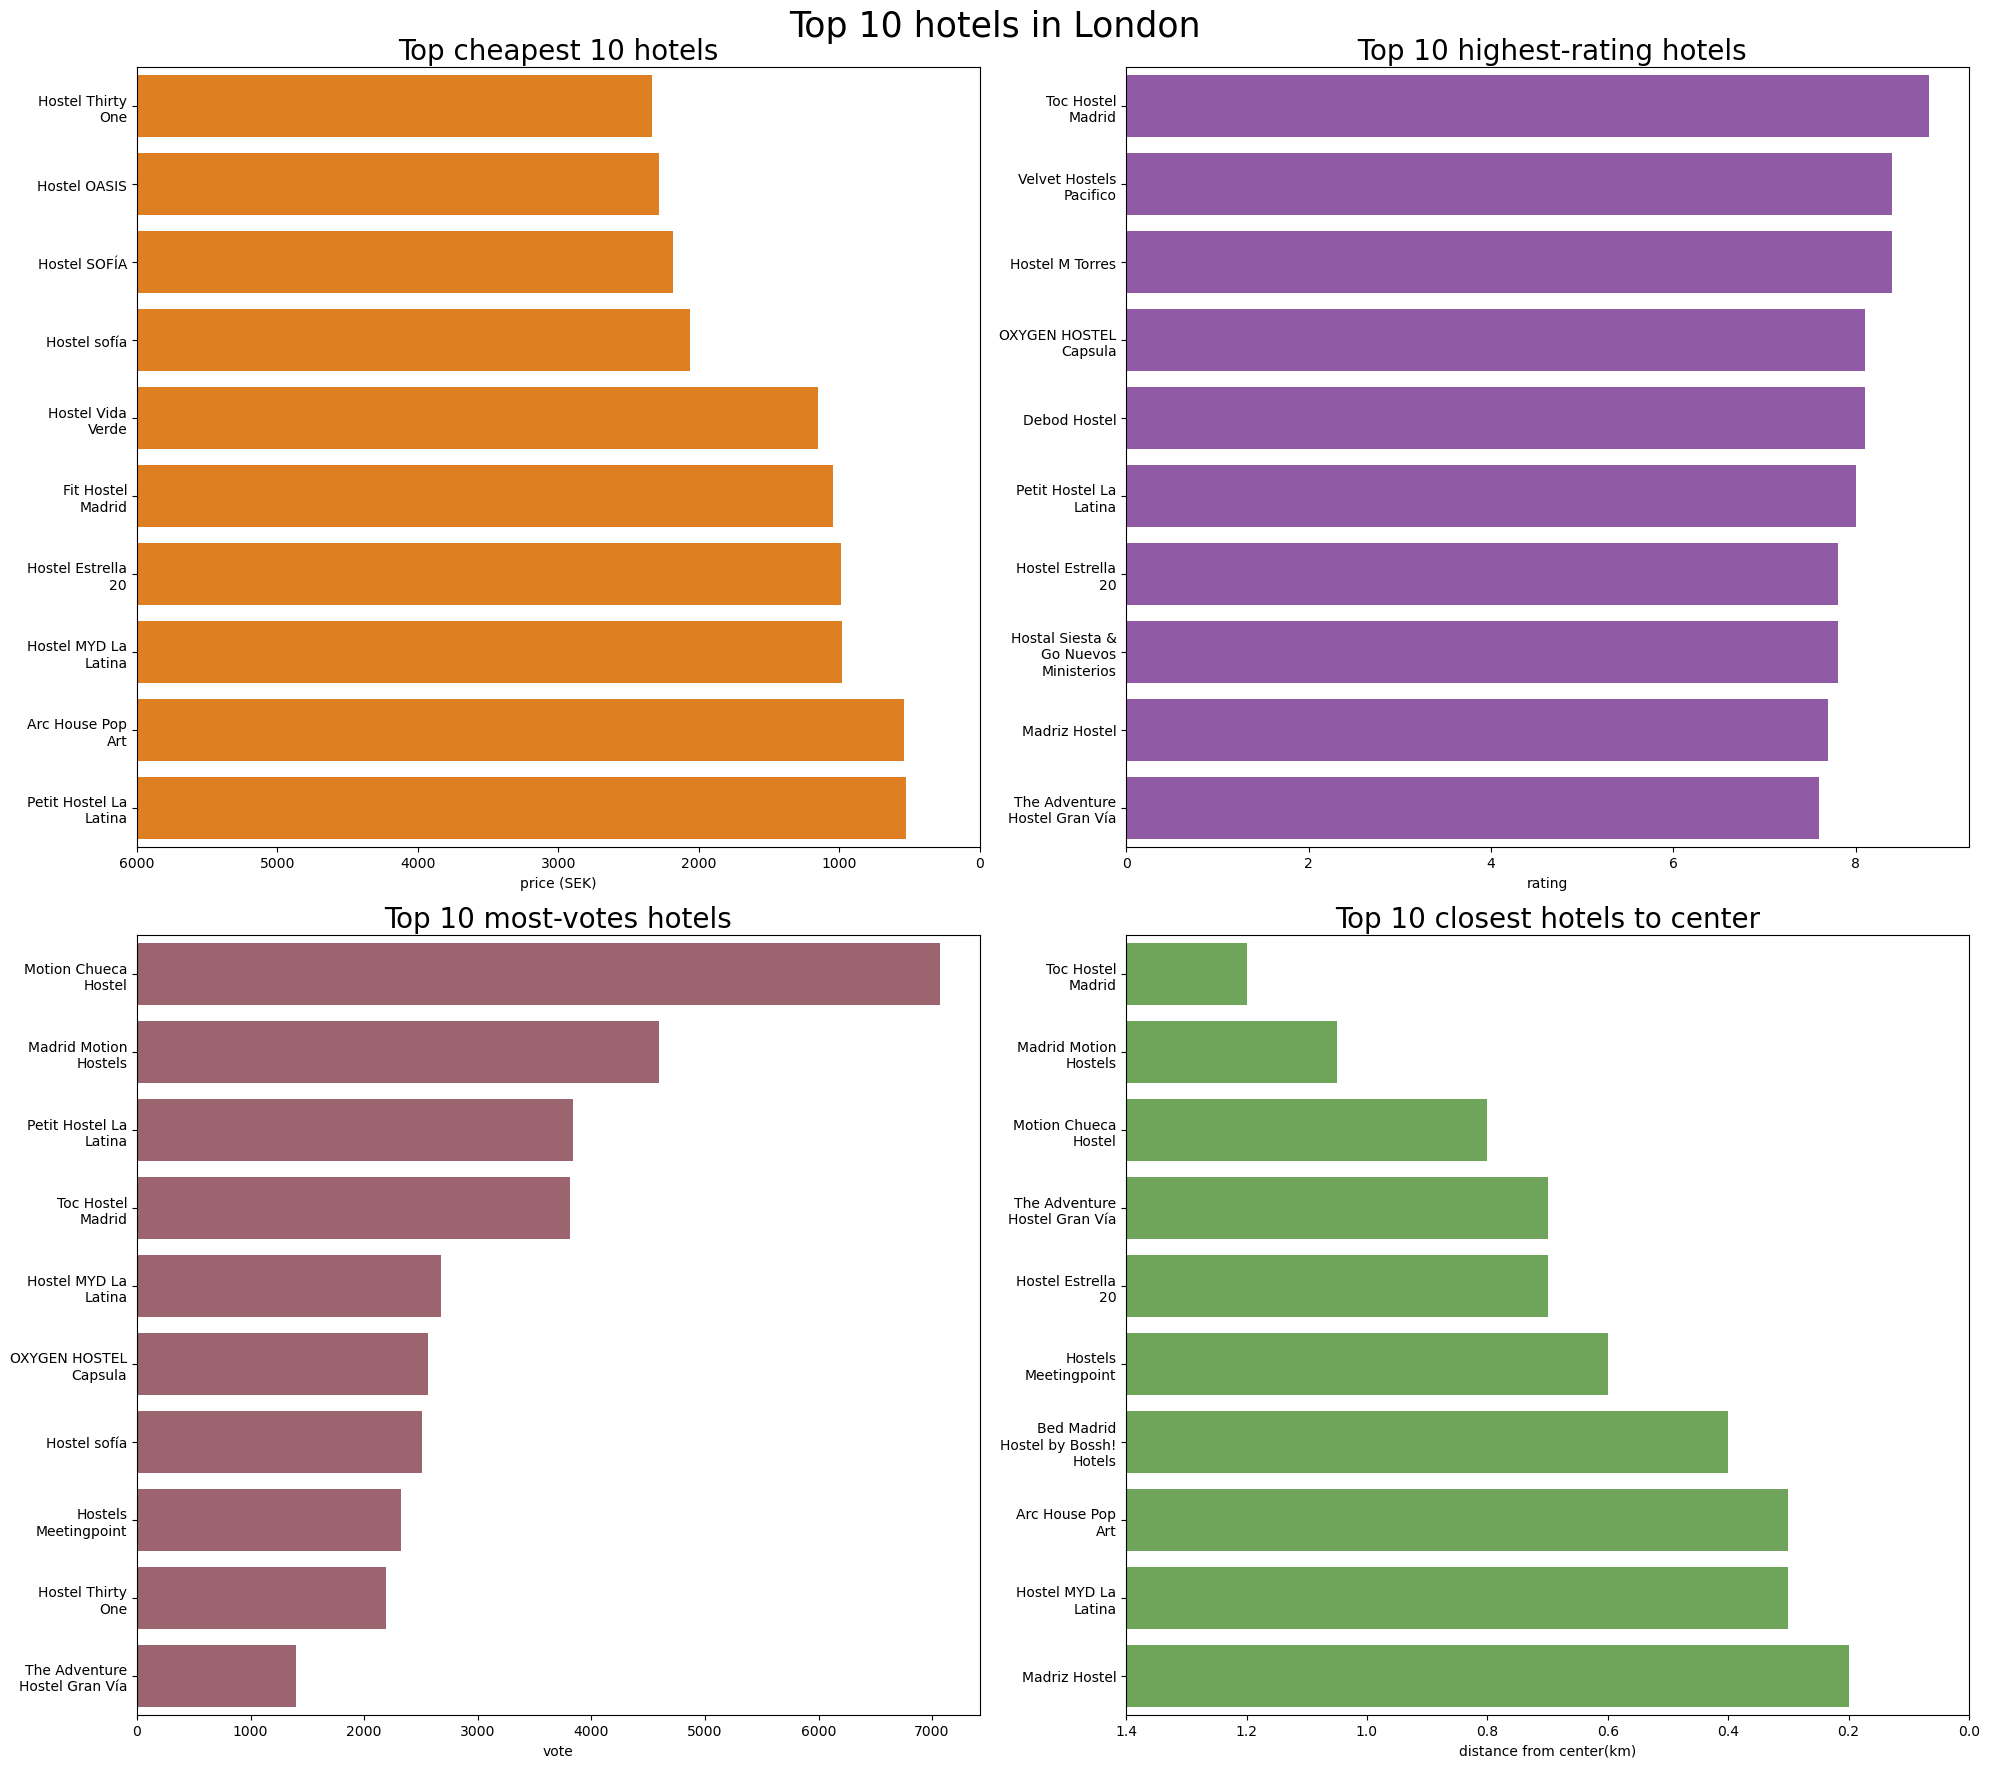

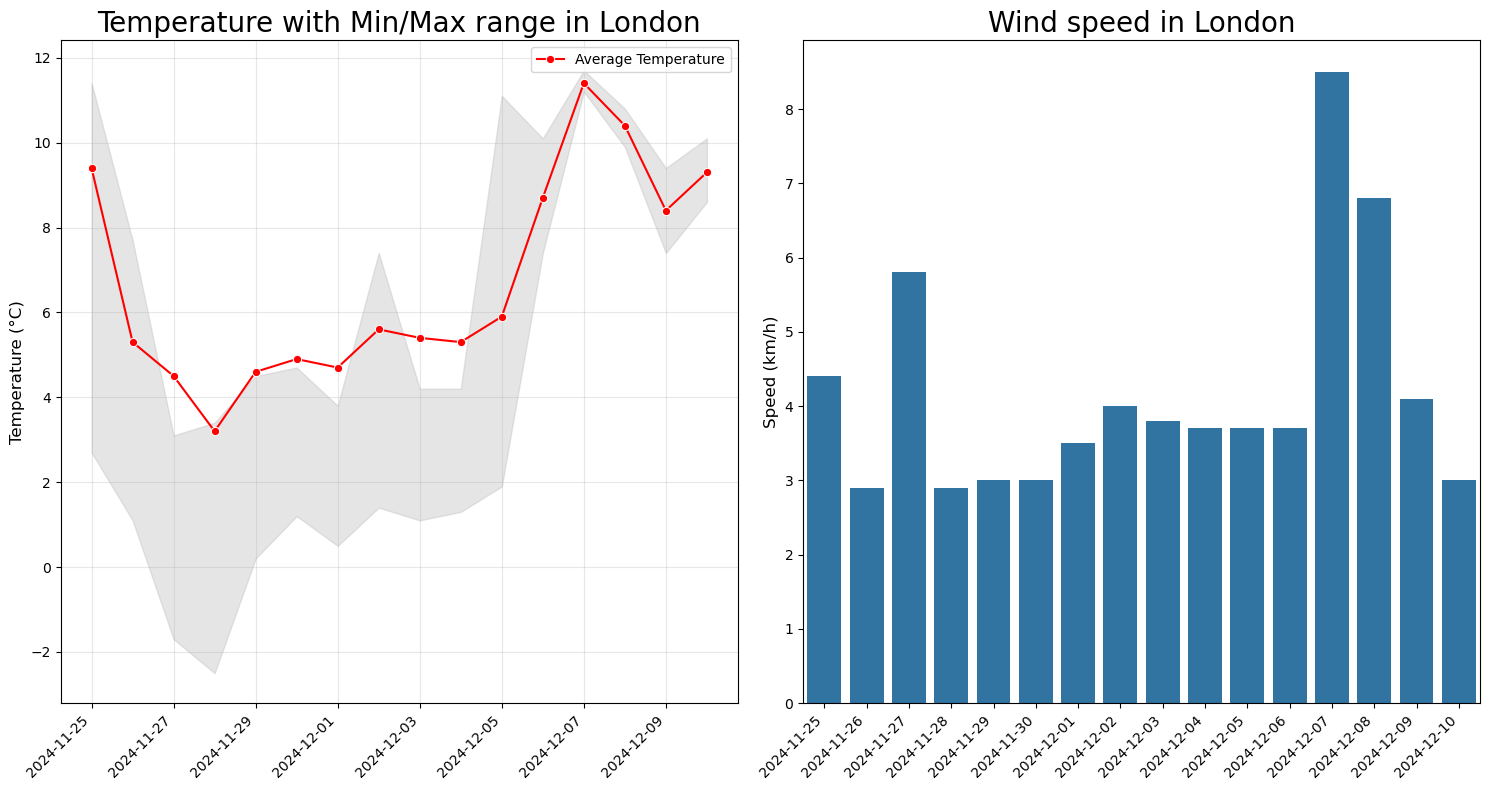

In [ ]:
# Main functon:

#-------------------------------------GUI--------------------------------------------
# Set up the main window
root = tk.Tk()
root.title("Travel Booking Form")
root.geometry("700x600")
root.config(bg="#f5f5f5")

# Title
title_label = tk.Label(root, text="Travel Booking Form", font=("Arial", 16, "bold"), bg="#f5f5f5")
title_label.pack(pady=10)

# City Entry
city_label = tk.Label(root, text="City", bg="#f5f5f5")
city_label.pack()
city_entry = tk.Entry(root)
city_entry.pack(pady=5)

# Country Entry
country_label = tk.Label(root, text="Country", bg="#f5f5f5")
country_label.pack()
country_entry = tk.Entry(root)
country_entry.pack(pady=5)

# Check-in Date Entry
check_in_label = tk.Label(root, text="Check-in Date (YYYY-MM-DD)", bg="#f5f5f5")
check_in_label.pack()
check_in_entry = tk.Entry(root)
check_in_entry.pack(pady=5)

# Check-out Date Entry
check_out_label = tk.Label(root, text="Check-out Date (YYYY-MM-DD)", bg="#f5f5f5")
check_out_label.pack()
check_out_entry = tk.Entry(root)
check_out_entry.pack(pady=5)

# Adults Entry
adults_label = tk.Label(root, text="Number of Adults", bg="#f5f5f5")
adults_label.pack()
adults_entry = tk.Entry(root)
adults_entry.pack(pady=5)

# Children Entry
children_label = tk.Label(root, text="Number of Children", bg="#f5f5f5")
children_label.pack()
children_entry = tk.Entry(root)
children_entry.pack(pady=5)

# Children Entry
room_label = tk.Label(root, text="Number of rooms", bg="#f5f5f5")
room_label.pack()
room_entry = tk.Entry(root)
room_entry.pack(pady=5)

city_country_df = city_country_dataframe()

# Declare global variables at the top (before the functions)
location = None
period = None
num = None


# Submit Button
submit_button = tk.Button(root, text="Submit", bg="#4CAF50", fg="white", command=lambda:submit(city_country_df))
submit_button.pack(pady=20)

# Run the GUI
root.mainloop()

#-------------------------------------------Hotel data via webscraping-------------------------------------------------------
hotel_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

selector = []
selector = get_selector()

# load city, country dataframe

# get city_country_df
city_country_df = city_country_dataframe()
# input city, country

hotel_url = get_hotel_url(location,period,num)
#print(f"The url of booking website is: {hotel_url}\n")

container = get_container(hotel_url,hotel_headers)
dic_hotel = extract_hotel_web(container,selector,location)

hotel_df = pd.DataFrame()
hotel_df = pd.DataFrame(dic_hotel)
hotel_df.dropna(inplace=True)
# Save the DataFrame to a CSV file
hotel_df.to_csv("hotel_data_country.csv", index=False)



# -----------------Weather data via API-------------------
# Initialize connection
conn = http.client.HTTPSConnection(os.environ["weather_api_host"])
weather_headers = {
    'x-rapidapi-key': os.environ["weather_api_key"],
    'x-rapidapi-host': os.environ["weather_api_host"]
}

# get url 
weather_url = get_weather_url(location)

# Create a list all_weather_data to store all records
all_weather_data = []
all_weather_data = extract_weather_API(location[0],weather_url,conn,weather_headers)

# store data requested from API into dataframe for the convinience of analysis
# Create DataFrame from lsit all_weather_data
weather_df = pd.DataFrame()
weather_df = pd.DataFrame(all_weather_data)
# Save the DataFrame to a CSV file
weather_df.to_csv("weather_data_country.csv", index=False)



# --------------------------------------Visualize hotel data------------------------------------------------

#hotel_df = pd.read_csv("hotel_data_country.csv")

# in column "rating": value "Scored 5.9" delete "Scored", change the str type to float type
# in column "vote": value "321 reviews" delete "reviews", change the str type to int
# in column "distance": change column name "distance" to "distance from center(km)", change delete "km from centre", change the str type to float type
# in column "price": price 

hotel_df["rating"] = hotel_df["rating"].apply(lambda x: float(x.split(" ")[1]))
hotel_df["vote"] = hotel_df["vote"].apply(lambda x: int(x.split(" ")[0].replace(",","")))
hotel_df["distance"] = hotel_df["distance"].apply(lambda x: float(x.split(" ")[0]) if x.split(" ")[1]=='km' 
                                      else float(x.split(" ")[0])/1000 if x.split(" ")[1]=='m'
                                      else None)
hotel_df.rename(columns={"distance":"distance from center(km)"},inplace=True)

hotel_df["price"] = hotel_df["price"].apply(lambda x: float(x.split("\xa0")[1].replace(",","")))
hotel_df.rename(columns={"price":"price (SEK)"},inplace=True)


# set color
primary_colors = [ "#D83227","#42baa4","#974DB2","#f8ee07","#f90655","#184fe7"]   
secondary_colors = ["#68B24D","#fd7f02","#3e73ba","#d15b9f","#a45b68"]
contrast_colors=["#13d5ec"]

tian_colors = primary_colors + secondary_colors + contrast_colors


# draw a figure
fig,ax_hot = plt.subplots(2,2,figsize=(20,18))

# Top 10 chepest hotels:
hotel_top_10_cheap = hotel_df.sort_values(by="price (SEK)",ascending=True).iloc[:10]
city = hotel_top_10_cheap.loc[0,"city"]
sns.barplot(data=hotel_top_10_cheap,x="price (SEK)",y="name",orient="h",errorbar=None,color=secondary_colors[1],ax=ax_hot[0,0])
ax_hot[0,0].set_title("Top cheapest 10 hotels",fontsize=20)
ax_hot[0,0].set_ylabel("",fontsize=12)

# Get the current x-tick positions
x_ticks = ax_hot[0, 0].get_xticks()
# Reverse the x-tick positions (this keeps the plot direction the same)
reversed_ticks = x_ticks[::-1]
ax_hot[0, 0].set_xticks(reversed_ticks)
# Get current x-tick labels and reverse them
# get_xticklabels() gives you the actual label objects, 
# so we use get_text() to extract the text (i.e., the labels) from those objects, and then reverse them
x_labels = [label.get_text() for label in ax_hot[0, 0].get_xticklabels()]
ax_hot[0, 0].set_xticklabels(x_labels[::-1])  # Set the reversed labels

# wrap the y-tick lables to 2 lines
lables = ax_hot[0,0].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# Fix y-tick positions with FixedLocator
ax_hot[0, 0].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[0, 0].set_yticklabels(wrapped_labels)

# Top 10 highest-rating hotels:
hotel_top_10_cheap = hotel_df.sort_values(by="rating",ascending=False).iloc[:10]
sns.barplot(data=hotel_top_10_cheap,x="rating",y="name",orient="h",errorbar=None,color=primary_colors[2],ax=ax_hot[0,1])
ax_hot[0,1].set_title(" Top 10 highest-rating hotels",fontsize=20)
ax_hot[0,1].set_ylabel("",fontsize=12)
# wrap the y-tick lables to 2 lines
lables = ax_hot[0,1].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# set_yticklabels(): After wrapping the labels, we set them back to the x-axis with rotation for better readability.
ax_hot[0, 1].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[0, 1].set_yticklabels(wrapped_labels)

# Top 10 most-votes hotels:
hotel_top_10_cheap = hotel_df.sort_values(by="vote",ascending=False).iloc[:10]
sns.barplot(data=hotel_top_10_cheap,x="vote",y="name",orient="h",errorbar=None,color=secondary_colors[4],ax=ax_hot[1,0])
ax_hot[1,0].set_title("Top 10 most-votes hotels",fontsize=20)
ax_hot[1,0].set_ylabel("",fontsize=12)
# wrap the x-tick lables to 2 lines
lables = ax_hot[1,0].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# set_xticklabels(): After wrapping the labels, we set them back to the x-axis with rotation for better readability.
ax_hot[1, 0].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[1, 0].set_yticklabels(wrapped_labels)

# Top 10 closest hotels to center:
hotel_top_10_cheap = hotel_df.sort_values(by="distance from center(km)",ascending=True).iloc[:10]
sns.barplot(data=hotel_top_10_cheap,x="distance from center(km)",y="name",orient="h",errorbar=None,color=secondary_colors[0],ax=ax_hot[1,1])
ax_hot[1,1].set_title("Top 10 closest hotels to center",fontsize=20)
ax_hot[1,1].set_ylabel("",fontsize=12)

# Get the current y-tick positions
x_ticks = ax_hot[1, 1].get_xticks()
# Reverse the y-tick positions (this keeps the plot direction the same)
reversed_ticks = x_ticks[::-1]
ax_hot[1, 1].set_xticks(reversed_ticks)
# Get current y-tick labels and reverse them
# get_yticklabels() gives you the actual label objects, 
# so we use get_text() to extract the text (i.e., the labels) from those objects, and then reverse them
x_labels = [label.get_text() for label in ax_hot[1, 1].get_xticklabels()]
ax_hot[1, 1].set_xticklabels(x_labels[::-1])  # Set the reversed labels

# wrap the y-tick lables to 2 lines
lables = ax_hot[1,1].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# set_yticklabels(): After wrapping the labels, we set them back to the x-axis with rotation for better readability.
ax_hot[1, 1].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[1, 1].set_yticklabels(wrapped_labels)

plt.suptitle(f"Top 10 hotels in {city}",fontsize=25)
plt.tight_layout()
plt.savefig("hotel_recommendation.png", transparent = False, bbox_inches="tight")
plt.show()



#-------------------------------------Visualize weather data-------------------------------------------------------
# 1. only select three columns: city, date, temp, weather; 
# 2. replace the columns "{'code': 801, 'icon': 'c02n', 'description': 'Few clouds'}" with {'Few clouds'};
# 3. deal with datetime: only select day rows groubpy city;

weather_df = weather_df[["city","datetime", "weather", "temp","app_max_temp","app_min_temp","snow_depth","wind_spd"]]
# Convert the 'weather' column from string to dictionary because now the 'weather' column is not dictionary but string.
# The apply method is used to apply a function to each element in the column;
# df_1(lambda x: x["weather"] = dic['description'] for dic in x["weather"]) 
weather_df["weather"] = weather_df["weather"].apply(lambda x: x['description'])    

# filter out the weather during the input period
# filter the datafrmae for date between check_in_date and check_out_date
check_in_date = period[0]
check_out_date = period[1]

# Ensure weather_df["datetime"] is in datetime format
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])

filter_weather_df = weather_df[(weather_df["datetime"] >= check_in_date) & (weather_df["datetime"] <= check_out_date)]


# plot the weather over days

fig,ax_wea= plt.subplots(1,2,figsize=(15,8))

# temperature
sns.lineplot(data=filter_weather_df,x="datetime",y="temp",label="Temperature",color="red",marker="o",ax=ax_wea[0])
ax_wea[0].fill_between(filter_weather_df["datetime"],filter_weather_df["app_min_temp"],filter_weather_df["app_max_temp"],color="#BFBFBF", alpha=0.4)
ax_wea[0].set_title(f'Temperature with Min/Max range in {city}', fontsize=20)
ax_wea[0].set_xlabel('',fontsize=12)
ax_wea[0].set_ylabel('Temperature (°C)',fontsize=12)
ax_wea[0].tick_params(axis="x",rotation=45)
# Set ha="right" for x-axis tick labels
for label in ax_wea[0].get_xticklabels():
    label.set_horizontalalignment('right')
ax_wea[0].legend()
ax_wea[0].grid(True, alpha=0.3)


# wind speed
sns.barplot(data=filter_weather_df,x="datetime",y="wind_spd",ax=ax_wea[1])
ax_wea[1].set_title(f'Wind speed in {city}', fontsize=20)
ax_wea[1].set_xlabel('',fontsize=12)
ax_wea[1].set_ylabel('Speed (km/h)',fontsize=12)
ax_wea[1].tick_params(axis="x",rotation=45)
# Set ha="right" for x-axis tick labels
for label in ax_wea[1].get_xticklabels():
    label.set_horizontalalignment('right')
#ax_wea[1].legend()

plt.tight_layout()
plt.savefig("weather_forcast", transparent = False, bbox_inches="tight")
plt.show()


In [7]:
print(check_in_date)
print(check_out_date)

2024-11-25 00:00:00
2024-12-12 00:00:00


In [8]:
hotel_df

,city,country,name,price (SEK),rating,vote,distance from center(km)
0,London,United Kingdom,Hostel Thirty One,3669.0,5.3,2190,3.90
1,London,United Kingdom,Hostel OASIS,3715.0,6.4,131,4.30
2,London,United Kingdom,Hostel SOFÍA,3819.0,4.8,601,6.10
3,London,United Kingdom,Hostel sofía,3934.0,5.5,2505,6.10
4,London,United Kingdom,Hostel Vida Verde,4845.0,5.6,201,7.70
5,London,United Kingdom,Fit Hostel Madrid,4954.0,5.7,203,1.40
6,London,United Kingdom,Hostel Estrella 20,5015.0,7.8,196,0.70
7,London,United Kingdom,Hostel MYD La Latina,5018.0,6.2,2675,1.10
8,London,United Kingdom,Arc House Pop Art,5464.0,6.3,546,1.10
9,London,United Kingdom,Petit Hostel La Latina,5476.0,8.0,3842,1.40


In [9]:
weather_df

,city,datetime,weather,temp,app_max_temp,app_min_temp,snow_depth,wind_spd
0,London,2024-11-25,Light shower rain,9.4,11.4,2.7,0,4.4
1,London,2024-11-26,Broken clouds,5.3,7.7,1.1,0,2.9
2,London,2024-11-27,Heavy rain,4.5,3.1,-1.7,0,5.8
3,London,2024-11-28,Scattered clouds,3.2,3.4,-2.5,0,2.9
4,London,2024-11-29,Broken clouds,4.6,4.5,0.2,0,3.0
5,London,2024-11-30,Broken clouds,4.9,4.7,1.2,0,3.0
6,London,2024-12-01,Broken clouds,4.7,3.8,0.5,0,3.5
7,London,2024-12-02,Overcast clouds,5.6,7.4,1.4,0,4.0
8,London,2024-12-03,Broken clouds,5.4,4.2,1.1,0,3.8
9,London,2024-12-04,Broken clouds,5.3,4.2,1.3,0,3.7
